<a href="https://colab.research.google.com/github/quantaosun/pl3/blob/main/Free_Cloud_Docking_2D_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programmatic Molecular Docking 

### Based on Vina-derived Smina. Obabel is used to calculate the protein charges. The docking grid is defined as the centre of the native ligand.

- This notebook is written by https://github.com/quantaosun
- what you get is ***the docking score + docked complex + a 2D image + a 3D interaction pymol session file*** 
- the docked complex and 2D image are readily to be used, The 3D pymol session need to be downloaded to a local pymol for further polish if you want a publication quality

# Please provide PDB ID and ligand structure you want to dock with

In [1]:
#@title Input expected from the user
path = "." #@param {type:"string"}
%cd '{path}'
PDB_ID = "3HTB" #@param {type:"string"}
pdb = PDB_ID + ".pdb"
! wget https://files.rcsb.org/download/$pdb
#@title Ligand three-letter name
Ligand = "JZ4" #@param {type:"string"}
smiles = "c1ccccc1" #@param {type:"string"}


/home/qq/baidu_tongbu_kongjian/chapter2-Modelling/QS07/DYRK1A
--2023-06-13 18:57:03--  https://files.rcsb.org/download/4YLK.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.134
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: '4YLK.pdb’

4YLK.pdb                [   <=>              ] 579.10K   601KB/s    in 1.0s    

2023-06-13 18:57:05 (601 KB/s) - '4YLK.pdb’ saved [593001]



# Import libraries

In [2]:
#!./smina.static -h
import sys
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
print(rdBase.rdkitVersion)

2022.09.4


# Prepare receptor

In [3]:
#@title Write out a script for pymol
com_file = open('split.pml','w')
com_file.write('''
load 3HTB.pdb
remove resn HOH
h_add elem O or elem N
select 3HTB-JZ4, resn JZ4 #Create a selection called 1OYT-FSN from the ligand
select 3HTB-receptor, 3HTB and not 3HTB-JZ4 #Select all that is not the ligand
save 3HTB-JZ4.pdb, 3HTB-JZ4
save 3HTB-receptor.pdb, 3HTB-receptor    
''')
com_file.close()

In [4]:
#@title Correct the script with right PDB ID and ligand name
!sed -i 's/3HTB/{PDB_ID}/g' split.pml
!sed 's/JZ4/{Ligand}/g' split.pml
!sed -i 's/JZ4/{Ligand}/g' split.pml


load 4YLK.pdb
remove resn HOH
h_add elem O or elem N
select 4YLK-4E2, resn 4E2 #Create a selection called 1OYT-FSN from the ligand
select 4YLK-receptor, 4YLK and not 4YLK-4E2 #Select all that is not the ligand
save 4YLK-4E2.pdb, 4YLK-4E2
save 4YLK-receptor.pdb, 4YLK-receptor    


In [5]:
#@title Run pymol to split protein and native ligand
%cd '{path}'
! pymol -c split.pml

/home/qq/baidu_tongbu_kongjian/chapter2-Modelling/QS07/DYRK1A
 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 16 CPU cores.  Enabled multithreaded rendering.
PyMOL>load 4YLK.pdb
HEADER    TRANSFERASE/TRANSFERASE INHIBITOR       05-MAR-15   4YLK
TITLE     CRYSTAL STRUCTURE OF DYRK1A IN COMPLEX 

# Variable assignment

In [6]:
Protein_PDB_file_name = PDB_ID + '-receptor.pdb'
ligand_name = PDB_ID + '-' + Ligand + '.pdb'

# PDBFixer to prepare the receptor

In [7]:
!pdbfixer  {Protein_PDB_file_name} --ph=7  --replace-nonstandard --add-residues 

In [8]:
!cat output.pdb > receptor.pdb

# Caculating charges for receptor

In [9]:
#@title Target and native ligand preparation before docking
#!obabel {Protein_PDB_file_name} -xr -O receptor.pdbqt
!obabel receptor.pdb -xr -O receptor.pdbqt
!obabel {ligand_name} -O native_ligand.pdbqt

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is receptor.pdb)

1 molecule converted
1 molecule converted


# Prepare ligand

In [10]:
#@title Convert SMILE strings to SDF format
!echo "{smiles}" > ligand2.smi
!obabel ligand2.smi -osdf -O small.sdf --gen3d

1 molecule converted


In [11]:
#@title Define small ligand path and number
# File locations
sdfFilePath = 'small.sdf' #@param {type:"string"}
ConfoutputFilePath = 'small_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [12]:
#@title SDF conformation generation for small molecule

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time: 0:00:00 |#################################|


# Define Docking inputs variables

In [13]:
#@title 👋 Input names needed for Dock1
ProteinForDocking = "receptor.pdbqt" #@param {type:"string"}
LigandFromProtein = "native_ligand.pdbqt" #@param {type:"string"}
Docked_out_FilePath = "Docked.pdb" #@param {type:"string"}
FlexibleDockedFilePath = "FlexibleDocked.sdf.gz" #@param {type:"string"}

# Docking 

In [14]:
#@title  Normal Docking (docking box is 8Å greater than the ligand specified. The –exhaustiveness is 8 )
!smina.static --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}'  -o '{Docked_out_FilePath}'

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

# ⚠️⚠️(Alternatively, if you are patient enough, try this slow but mor accurate docking),otherwise just skip this

In [15]:
#@title ⚠️Flexible docking, use with caution, it take super long time。 You can just skip unless you really want a relative accurate docking.
#!./smina.static --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' --flexdist_ligand '{LigandFromProtein}' --flexdist 5 -o '{Docked_out_FilePath}'

# Convert docked ligand to sdf

In [16]:
!obabel Docked.pdb -O Docked.sdf

18 molecules converted


# Visulization of Docked result





In [17]:
#@title Define display style
#@title Define receptor name
TargetProtein = Protein_PDB_file_name
def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '132'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '147'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer 

In [18]:
#@title Import visualization software

import py3Dmol

def drawit2(m,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p

def DrawComplex(protein,ligand):
    complex_pl = Chem.MolToPDBBlock(Chem.CombineMols(protein,ligand))
    #complex_mol=Chem.CombineMols(receptor,mols[-1])
    view = py3Dmol.view(width=600,height=600)
    view.addModel(complex_pl,'pdb')
    #view.addModel(Chem.MolToMolBlock(mols[0]),'sdf')
    chA = {'chain':['H','L','I']}
    chB = {'resn':'UNL'}
    view.setStyle(chA,{'cartoon': {'color':'spectrum'}})
    #view.setStyle(chA,{'lines': {}})
    view.addSurface(py3Dmol.VDW,{'opacity':0.8}, chB)
    view.setStyle(chB,{'stick':{}})
    view.zoomTo()
    return view   


In [19]:
#@title View docked ligand
#pose = "2" #@param ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
mols = [m for m in Chem.SDMolSupplier('Docked.sdf') if m is not None]
#drawit2(mols[1])

In [20]:
#@title Show docked top1 (zoom out)
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawComplex(receptor,mols[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
#@title Show the docked pocket (zoom in)
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawDocking(receptor,mols[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Export the receptor and fix it with PDBfixer,
Before receptor is merged, we want to make sure it is well fixed

In [22]:
# merge the docked pose and the receptor

In [23]:
#!conda install -c conda-forge openmm -y 2>&1 1>/dev/null
#!conda install -c conda-forge pdbfixer -y 2>&1 1>/dev/null

In [24]:
#@ Title To make sure the correct charge for MDanalysis, fix it again
#!pdbfixer  {Protein_PDB_file_name} --ph=7  --replace-nonstandard --add-residues 

# Export the top1 docked ligand and add H.
To achieve this, we convert pdb to mol2, then back to pdb. 

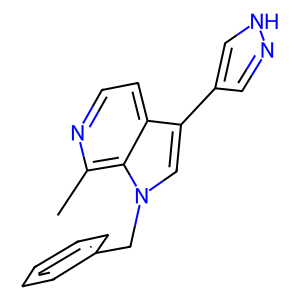

In [25]:
m=Chem.MolFromPDBFile('Docked.pdb')
Draw.MolToImage(m)

In [26]:
!obabel -ipdb Docked.pdb -omol2 -O Docked.mol2 -m -h

18 molecules converted
18 files output. The first is Docked1.mol2


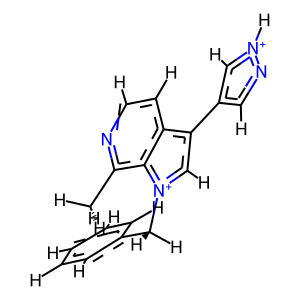

In [27]:
m=Chem.MolFromMol2File('Docked1.mol2',sanitize=False)
Draw.MolToImage(m)

In [28]:
!obabel -imol2 Docked1.mol2 -opdb -O Docked1.pdb -h

1 molecule converted


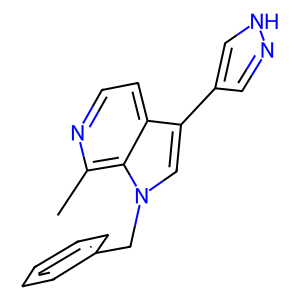

In [29]:
m=Chem.MolFromPDBFile('Docked1.pdb')
Draw.MolToImage(m)

#Merge the docked TOP1 and the receptor

In [30]:
#@title Write out a script for merge
com_file = open('merge.pml','w')
com_file.write('''
load output.pdb
load Docked1.pdb
h_add elem O or elem N
save complex_prepared.pdb, all   
''')
com_file.close()

In [31]:
!pymol -c merge.pml # output.pdb is the default output name

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 16 CPU cores.  Enabled multithreaded rendering.
PyMOL>load output.pdb
 ObjectMolecule: Read crystal symmetry information.
 CmdLoad: "" loaded as "output".
PyMOL>load Docked1.pdb
COMPND    Docked.pdb
 CmdLoad: "" loaded as "Docked1".
PyMOL>h_add e

# Install dependencies for 2D interaction

In [32]:
import MDAnalysis as mda
import prolif as plf

# Define the merged complex as a MDAnalysis object

In [33]:
import numpy as np
# load topology
u = mda.Universe('complex_prepared.pdb')
lig = u.select_atoms("resname UNL")
prot = u.select_atoms("protein")

# Clean up the ligand before 2D

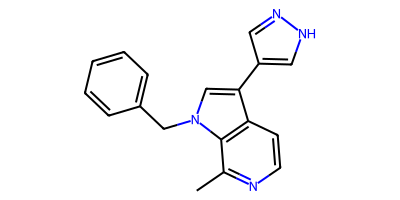

In [34]:
from rdkit import Chem
from rdkit.Chem import Draw

# create a molecule from the MDAnalysis selection
lmol = plf.Molecule.from_mda(lig)
# cleanup before drawing
mol = Chem.RemoveHs(lmol)
mol.RemoveAllConformers()
Draw.MolToImage(mol, size=(400, 200))

# Draw the 2D interaction

In [35]:
from prolif.plotting.network import LigNetwork

fp = plf.Fingerprint()
fp.run(u.trajectory[::10], lig, prot)
df = fp.to_dataframe(return_atoms=True)

net = LigNetwork.from_ifp(
    df,
    lmol,
    # replace with `kind="frame", frame=0` for the other depiction
    kind="aggregate",
    threshold=0.3,
    rotation=270,
)
net.display()

  0%|          | 0/1 [00:00<?, ?it/s]

/home/qq/anaconda3/envs/pl3/lib/python3.8/multiprocessing/reduction.py:51: UserWarning: Reader has no dt information, set to 1.0 ps
  cls(buf, protocol).dump(obj)
/home/qq/anaconda3/envs/pl3/lib/python3.8/site-packages/prolif/plotting/network.py:292: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.get_dummies(


# Towards 3D interaction images

The following section will help you obtain a publication-quality 3D protein-ligand interaction image.
- A Pymol pre_pymol.pse file will be generated 
- The pse file shows the residues within 5 angstroms of ligand
- You are supposed to download the pse to finish the drawing of the interaction lines like H bond dash lines and hydrophobic interaction lines since these lines are pretty challenging to process programmatically due to it varying too much from protein to protein

In [36]:
#@title 2. 👋 Write pymol script
com_file = open('image.pml','w')
com_file.write('''
load output.pdb, tmp
load Docked1.pdb, docked
#select the surrounding then set it to an object 
# find 5 angstroms around ligand
select resn UNL
select res, byres sele around 5
#set the ligand to an lig object
select lig, resn UNL
# Select all to hide
select all
# hide everythong
hide
# show the ligand and surroundings
show sticks, lig|res
# hide the H atom on the sticks
hide sticks, h.
# zoon on lig and res, background faded
zoom lig|res
# Color ligand carbon atom yellow
color yellow, lig&name C*
# Color ligand carbon atom yellow
color cyan, res&name C*
# Set label and font size
# note you still have to click "residues" form L dropdown menue to show the label
set label_size, 28
set label_font_id, 8
set label_color, grey
# We also define some hydrophobic interaction style
set sphere_scale, 0.35
set sphere_transparency, 0.3
set sphere_color, cyan
# Define some hydrogen bond. interaciton style
set dash_length, 0.3
set dash_radius, 0.08
set dash_gap, 0.3
# set backgroud white
bg_color white
show cartoon
set cartoon_transparency, 0.3
bg_color white
set ray_trace_mode, 1
png binding_pocket.png
save pre_pymol.pse
''')
com_file.close()


# Generate a 3D pymol session

In [37]:
#@title 4.👋 Generate a pymol session pse file that 70% quality of publication, please download to polish it more.
!pymol -c image.pml


 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 16 CPU cores.  Enabled multithreaded rendering.
PyMOL>load output.pdb, tmp
 ObjectMolecule: Read crystal symmetry information.
 CmdLoad: "" loaded as "tmp".
PyMOL>load Docked1.pdb, docked
COMPND    Docked.pdb
 CmdLoad: "" loaded as "docked".
PyMO

# Please download pre_pymol.pse to continue making the image with your local Pymol

# References

All the dependencies used are open soured, they are 

*   rdkit
*   openbabel
*   py3Dmol 
*   pymol-open-source 
*   smina.static
*   MDAnalysis
*   ProLif
*   Python 3.8
*   conda
*   colab conda

- This notebook has referred [Is life worth living](https://www.cheminformania.com/ligand-docking-with-smina/)
- Thi notebook has referred [Jupyter Notebook for docking either locally or using Colab](https://www.macinchem.org/reviews/JupyterDocking/jupyterdocking.php)
 

## Post MD simulatio for top 3 poses
Please copy Docked1.pdb, Docked2.pdb and Docked3.pdb to a folder called ligands.

In [38]:
import os
import glob
import numpy as np
from simtk import unit, openmm
from simtk.openmm import app
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openmmforcefields.generators import SystemGenerator


# Define file paths
protein_file = "Output.pdb"
ligand_dir = "ligands"
ligand_files = glob.glob(os.path.join(ligand_dir, "*.pdb"))
output_dir = "output"

# Load the protein and create a topology
pdb = app.PDBFile(protein_file)
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')
modeller = app.Modeller(pdb.topology, pdb.positions)
topology = modeller.getTopology()

# Create a SystemGenerator
ff = ForceField("openff-1.3.0.offxml")
system_generator = SystemGenerator(
    forcefields=["amber14-all.xml", "amber14/tip3p.xml"],
    small_molecule_forcefield=ff,
    molecules=[],
    cache=None
)

# Loop over the ligand files
for i, ligand_file in enumerate(ligand_files):
    print(f"Processing ligand file {i+1}/{len(ligand_files)}: {os.path.basename(ligand_file)}")
    
    # Create a Molecule object for the ligand
    ligand_mol = Molecule.from_file(ligand_file)

    # Generate the topology and system for the ligand
    ligand_top = Topology.from_molecules(ligand_mol)
    ligand_sys = system_generator.create_system(ligand_top)

    # Add the ligand to the modeller and merge topologies
    modeller.add(ligand_mol.to_topology().to_openmm())
    topology = modeller.getTopology()

    # Create a combined system and set up simulation
    system = forcefield.createSystem(
        topology,
        nonbondedMethod=app.PME,
        nonbondedCutoff=1.0*unit.nanometers,
        constraints=app.HBonds,
        rigidWater=True,
        ewaldErrorTolerance=0.0005
    )
    system.addForce(ligand_sys.getForce(0))
    integrator = openmm.LangevinIntegrator(
        300*unit.kelvin, 1.0/unit.picosecond, 2.0*unit.femtoseconds
    )
    platform = openmm.Platform.getPlatformByName("CUDA")
    properties = {'CudaPrecision': 'mixed'}
    simulation = app.Simulation(topology, system, integrator, platform, properties)
    simulation.context.setPositions(modeller.positions)

    # Run simulation
    simulation.reporters.append(app.DCDReporter(os.path.join(output_dir, f"ligand{i+1}.dcd"), 250))
    simulation.reporters.append(app.StateDataReporter(os.path.join(output_dir, f"ligand{i+1}.csv"), 250, step=True, 
                                                       time=True, potentialEnergy=True, kineticEnergy=True, 
                                                       totalEnergy=True, temperature=True))
    simulation.reporters.append(app.CheckpointReporter(os.path.join(output_dir, f"ligand{i+1}.chk"), 250))

    print("Running simulation...")
    simulation.step(5000)
    print("Done!")


ModuleNotFoundError: No module named 'openff'